In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

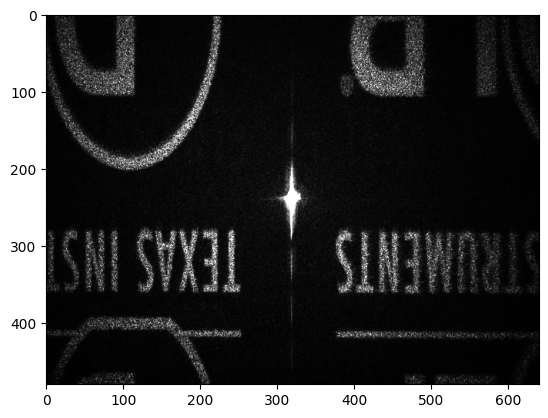

In [3]:
image=cv2.imread('test_image.bmp', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

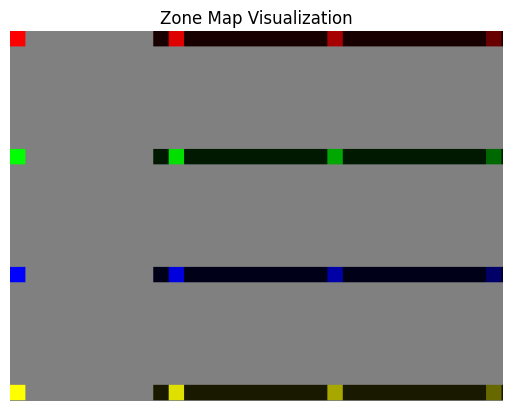

In [19]:
# We want to create a zone map for the image
# Each zone is defined by a a tuple of coordinates (zone_id, zone_offset, zone_size).
# They share the same w_offset and w_size.

def apply_zone_map_2_image (image, w_offset, w_size, n_partitions, zones):
    '''
        Arguments;
            - image: np.ndarray Image to apply the zone map to.
            - w_offset: int Width offset of the zone map. Shared by all zones.
            - w_size: int Width size of the zone map. Shared by all zones.
            - n_partitions: int Number of partitions per zone.
            - zones: List of tuples (zone_id, zone_offset, zone_size)
        Returns:
            - np.ndarray: Image with zones visualized as different colors. 
    '''
    dim = image.shape
    # Calculate the new dimensions of the resulting image
    new_dim = list(dim)
    
    global_zone_offset = zones[0][0]
    zone_size = zones[0][2]
    new_dim[0] = len(zones) * zone_size
    new_dim[1] = dim[1] - 2 * w_offset
    zone_map = np.zeros(shape=new_dim, dtype=np.uint8)

    for zone_id, zone_offset, zone_size in zones:
        roi = image[zone_offset:zone_offset + zone_size, w_offset:w_offset + w_size]

        start_y = zone_id * (zone_size + global_zone_offset)
        end_y   = start_y + zone_size
        zone_map[start_y:end_y,:] = roi

    return zone_map

def visualize_zones(dim, w_offset, w_size, n_partitions, zones):
    '''
        Arguments;
            - dim: (height, width) of the image
            - w_offset: int Width offset of the zone map. Shared by all zones.
            - w_size: int Width size of the zone map. Shared by all zones.
            - n_partitions: int Number of partitions per zone.
            - zones: List of tuples (zone_id, zone_offset, zone_size)
        Returns:
            - np.ndarray: Image with zones visualized as different colors. 
    '''
    zone_map = np.ones((dim[0], dim[1], 3), dtype=np.uint8) * 128

    # Predefined colors for zones depending on their ID. There is
    # a maximum of 8 zones for the aca640-750um.
    colors = [
        (255, 0, 0),    # Zone 0: Red
        (0, 255, 0),    # Zone 1: Green
        (0, 0, 255),    # Zone 2: Blue
        (255, 255, 0),  # Zone 3: Cyan
        (255, 0, 255),  # Zone 4: Magenta
        (0, 255, 255),  # Zone 5: Yellow
        (192, 192, 192),# Zone 6: Silver
        (128, 128, 128) # Zone 7: Gray
    ]

    for zone_id, zone_offset, zone_size in zones:
        color = colors[zone_id % len(colors)]
        default_color = np.array(color, dtype=np.float32) * 0.1
        zone_map[zone_offset:zone_offset + zone_size, w_offset:w_offset + w_size] = default_color

        # Use the same zone size to calculate the offsets needed
        # w_size = zone_size * n_partitions + (n_partitions - 1) * partition_width
        # implies that the partition width is calculated as:
        partition_width = (w_size - zone_size * n_partitions) // (n_partitions - 1)

        for i in range(n_partitions):

            partition_start = (i * (zone_size + partition_width))
            partition_end  = partition_start + zone_size

            # The brightness of the color is determined by index i
            # The minimum brightness is 0.5.
            # Thus the brightness is calculated as:
            brightness = (1 - (i / n_partitions)) * 0.5 + 0.5

            color = np.array(color, dtype=np.float32) * brightness

            zone_map[zone_offset:zone_offset + zone_size,
                     partition_start:partition_end] = color

    return zone_map

n_partitions = 4

w_d      = 20
w_offset = (image.shape[1] - n_partitions * w_d) // (n_partitions - 1)
w_size   = 3 * w_offset + 4 * w_d

h_offset = (image.shape[0] - n_partitions * w_d) // (n_partitions - 1)
h_size   = w_d

zones = []
for i in range(n_partitions):
    zone_id     = i
    zone_offset = (h_offset * i) + h_size * i
    zone_size   = h_size
    zones.append((zone_id, zone_offset, zone_size))
    
zone_map = visualize_zones(image.shape, w_offset, w_size, n_partitions, zones)
plt.imshow(zone_map)
plt.title("Zone Map Visualization")
plt.axis('off')
plt.show()




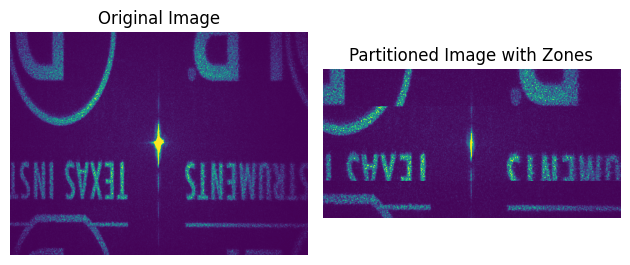

(240, 480)


In [96]:
viz = visualize_zones(image.shape, w_offset, w_size, n_partitions, zones)
partitioned_image = apply_zone_map_2_image(image, w_offset, w_size, n_partitions, zones)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.imshow(partitioned_image)
plt.title("Partitioned Image with Zones")
plt.axis('off')
plt.tight_layout()
plt.show()
print(partitioned_image.shape)

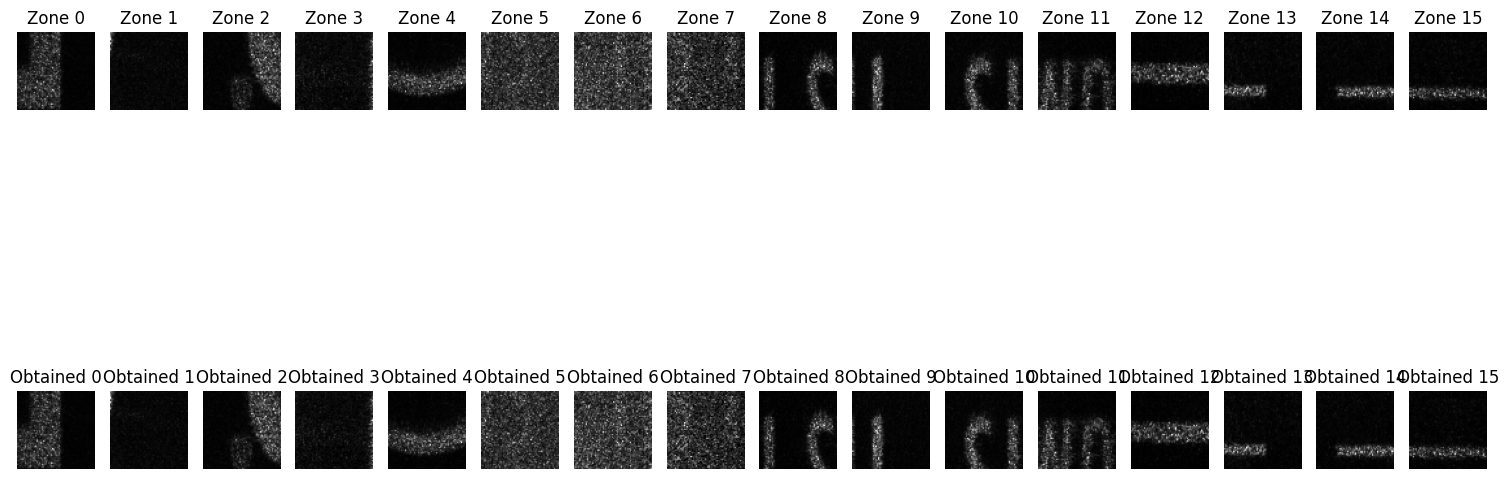

In [111]:
# Extract the zones from the partitioned image
def extract_zones(image, zone_size, n_partitions, w_offset): 
    '''
        Arguments:
            - image: np.ndarray Image to extract zones from.
            - zone_size: int Size of each zone.
        Returns:
            - List of tuples (zone_id, zone_offset, zone_size) for each zone.
    '''
    dim = image.shape
    n_zones_h = dim[0] // zone_size
    n_zones_w = dim[1] - (n_partitions - 1) * w_offset
    n_zones_w //= zone_size
    zones = []

    for h in range(n_zones_h):
        for w in range(n_zones_w):
            start_h = h * zone_size
            end_h   = start_h + zone_size
            start_w = w * (zone_size + w_offset)
            end_w   = start_w + zone_size
            zone = image[start_h:end_h, start_w:end_w]
            zones.append(zone)
    return zones

new_image = cv2.imread("Images/e24_image.png", cv2.IMREAD_GRAYSCALE)
new_zones = extract_zones(new_image, zone_size, n_partitions, w_offset)

obtained_images = [
    cv2.imread(f"Images/e24_image_{i}.png", cv2.IMREAD_GRAYSCALE)
    for i in range(16)
]

plt.figure(figsize=(15, 10))
for i in range(len(new_zones)):
    plt.subplot(2, len(new_zones), i + 1)
    plt.imshow(new_zones[i], cmap='gray')
    plt.title(f"Zone {i}")
    plt.axis('off')
for i in range(len(obtained_images)):
    plt.subplot(2, len(obtained_images), i + 1 + len(new_zones))
    plt.imshow(obtained_images[i], cmap='gray')
    plt.title(f"Obtained {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

(16, 60, 60)


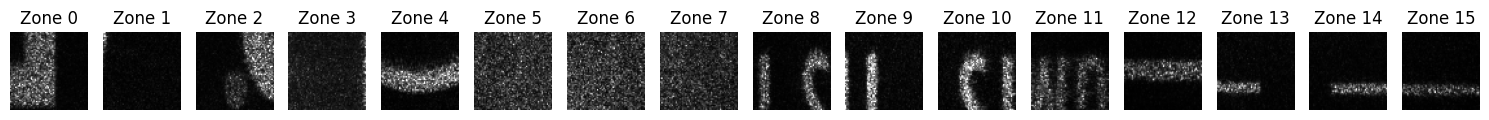

In [101]:
from numpy.lib.stride_tricks import as_strided

# Extract the zones from the partitioned image using only numpy operations (no loops)
def extract_zones(image, zone_size, n_partitions, w_offset):
    '''
        Arguments:
            - image: np.ndarray Image to extract zones from.
            - zone_size: int Size of each zone.
        Returns:
            - np.ndarray: Array of zones with shape (n_zones_h * n_zones_w, zone_size, zone_size, ...)
    '''
    dim = image.shape
    n_zones_h = dim[0] // zone_size
    n_zones_w = (dim[1] - (n_partitions - 1) * w_offset) // zone_size

    # Calculate the indices for the top-left corner of each zone
    starts_h = np.arange(n_zones_h) * zone_size
    starts_w = np.arange(n_zones_w) * (zone_size + w_offset)

    # Generate a grid of all top-left corners
    grid_h, grid_w = np.meshgrid(starts_h, starts_w, indexing='ij')
    grid_h = grid_h.flatten()
    grid_w = grid_w.flatten()

    # Use advanced indexing to extract all zones
    # Use numpy's as_strided to extract all zones without explicit loops

    shape = (
        n_zones_h,
        n_zones_w,
        zone_size,
        zone_size,
        *image.shape[2:]
    )
    strides = (
        image.strides[0] * zone_size,
        image.strides[1] * (zone_size + w_offset),
        image.strides[0],
        image.strides[1],
        *image.strides[2:]
    )
    zones = as_strided(image, shape=shape, strides=strides).reshape(-1, zone_size, zone_size, *image.shape[2:])
    return zones

zones_array = extract_zones(partitioned_image, zone_size, n_partitions, w_offset)

print(zones_array.shape)
plt.figure(figsize=(15, 5))
for i in range(len(new_zones)):
    plt.subplot(1, len(new_zones), i + 1)
    plt.imshow(new_zones[i], cmap='gray')
    plt.title(f"Zone {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()


(16, 60, 60)


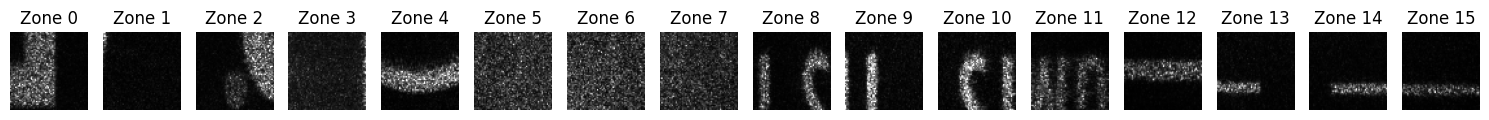

In [102]:
import torch

def extract_zones(image, zone_size, n_partitions, w_offset):
    '''
        Arguments:
            - image: torch.Tensor Image to extract zones from.
            - zone_size: int Size of each zone.
        Returns:
            - torch.Tensor: Tensor of zones with shape (n_zones_h * n_zones_w, zone_size, zone_size, ...)
    '''
    dim = image.shape
    n_zones_h = dim[0] // zone_size
    n_zones_w = (dim[1] - (n_partitions - 1) * w_offset) // zone_size

    starts_h = torch.arange(n_zones_h) * zone_size
    starts_w = torch.arange(n_zones_w) * (zone_size + w_offset)

    grid_h, grid_w = torch.meshgrid(starts_h, starts_w, indexing='ij')
    grid_h = grid_h.flatten()
    grid_w = grid_w.flatten()

    # Use advanced indexing to extract all zones at once
    idx_h = grid_h.unsqueeze(1) + torch.arange(zone_size).unsqueeze(0)
    idx_w = grid_w.unsqueeze(1) + torch.arange(zone_size).unsqueeze(0)

    # Expand to 2D grid for each zone
    idx_h = idx_h.unsqueeze(2).expand(-1, -1, zone_size)
    idx_w = idx_w.unsqueeze(1).expand(-1, zone_size, -1)

    # Gather zones
    if image.ndim == 2:
        zones = image[idx_h, idx_w]
    else:
        zones = image[idx_h, idx_w, :]

    return zones


zones_array = extract_zones(torch.from_numpy(partitioned_image), zone_size, n_partitions, w_offset).numpy()

print(zones_array.shape)
plt.figure(figsize=(15, 5))
for i in range(len(new_zones)):
    plt.subplot(1, len(new_zones), i + 1)
    plt.imshow(new_zones[i], cmap='gray')
    plt.title(f"Zone {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()
